# Introduction

For this tutorial, we will be analyzing the dataset of Bone Marrow Mononuclear Cells (BMMC) publicly available from [van Galen et al., Cell, 2019](https://doi.org/10.1016/j.cell.2019.01.031). van Galen et al. identified six malignant AML cell types that project along the HSC to myeloid differentiation axis, and linked them to disease progression and immunity. The processed data can be found [here](在这里插入数据连接). We applied sciNMF to this dataset, demonstrating its capability to detect the heterogeneity of AML malignant cells.

In [1]:
library(sciNMF)
library(Seurat)

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)



Registered S3 methods overwritten by 'treeio':
  method              from    
  MRCA.phylo          tidytree
  MRCA.treedata       tidytree
  Nnode.treedata      tidytree
  Ntip.treedata       tidytree
  ancestor.phylo      tidytree
  ancestor.treedata   tidytree
  child.phylo         tidytree
  child.treedata      tidytree
  full_join.phylo     tidytree
  full_join.treedata  tidytree
  groupClade.phylo    tidytree
  groupClade.treedata tidytree
  groupOTU.phylo      tidytree
  groupOTU.treedata   tidytree
  inner_join.

Following are main functions and data in sciNMF package

In [2]:
ls('package:sciNMF')

[1] "%>%"                "ClusterMetricsPlot" "ClusterPG"         
 [4] "EnrichDotPlot"      "IQRPlot"            "ls_gs_sciNMF"      
 [7] "MetaProgram"        "MPCoxph"            "OverlapMat"        
[10] "PGEnricher"         "RobustProgram"      "RunNMF"            
[13] "SrtObj"

# Run sciNMF workflow

## Setup the Seurat Object

In [3]:
# Load van Galen Seurat object
srt <- readRDS("Data/vanGalen2019.rds")
# Extract malignant cells 
srt <- subset(srt, subset=pred_Malignant=="Malignant")

## Run NMF for each sample

The **RunNMF** function conducts non-negative matrix factorization (NMF) analysis on the single-cell gene expression matrix for each sample.

Initially, the count matrices of each individual undergo normalization and scaling. Subsequently, the negative values in the scaled matrices are adjusted to zero. Finally, NMF is performed on the matrices for multiple ranks (from 3 to 8 by default).

The NMF W and H matrices for each individual will be stored in a list object, and then all the lists for individuals will be stored in a higher-level list object.

In [4]:
ls_WH <- RunNMF(srt, group.by = 'SampleNameNew', 
                    dir.output = './vanGalen2019_Result', # optional, if NULL, the result of pre sample will not be save as .rds file
                    project = 'vanGalen2019', # the prefix of result
                    k.range = 3:8, 
                    variable.features.n = 5000,
                    min.cell = 10, 
                    normalization.method = 'SCT',
                    seed = 777)# set a random seed to ensure the reproductivity of result

Start sample AML1012D0 -- Current time:2024-06-14 21:40:05.550991

Sample AML1012D0 done!

Start sample AML210AD0 -- Current time:2024-06-14 21:40:32.439924

Sample AML210AD0 done!

Start sample AML328D0 -- Current time:2024-06-14 21:40:48.772865

Sample AML328D0 done!

Start sample AML329D0 -- Current time:2024-06-14 21:41:14.001571

Sample AML329D0 done!

Start sample AML419AD0 -- Current time:2024-06-14 21:41:32.609695

Sample AML419AD0 done!

Start sample AML420BD0 -- Current time:2024-06-14 21:42:08.968122

Sample AML420BD0 done!

Start sample AML475D0 -- Current time:2024-06-14 21:42:22.888719

Sample AML475D0 done!

Start sample AML556D0 -- Current time:2024-06-14 21:42:43.120203

Sample AML556D0 done!

Start sample AML707BD0 -- Current time:2024-06-14 21:43:57.243483

Sample AML707BD0 done!

Start sample AML870D0 -- Current time:2024-06-14 21:44:50.501266

Sample AML870D0 done!

Start sample AML916D0 -- Current time:2024-06-14 21:45:11.828572

Sample AML916D0 done!

Start sampl

## QC and selecting programs for further analysis

We introduced two statistical measures to remove low-quality programs: (1) median and (2) interquartile range (IQR) of intra-rank normalized NMF usage. Specifically, normalization is performed on programs which were generated by the same NMF rank from same sample. Then, we calculated median and IQR of normalized NMF usage for each program. Lower median value indicates lower representativeness, outlying programs. IQR value describes the dispersion of program usage, higher IQR value suggests a program is activated in some cells while depressed in others. We assume that a meaningful program should satisfy two characteristics, that is, having sufficient representativeness (high median) and a wide distribution (high IQR). Therefore, using these two measures can eliminate potential low-quality programs.

**IQRPlot**    
Optional: `IQRPlot` is used to visualize Interquartile Range (IQR) and Median thresholds for filtering out low-quality programs based on within-rank normalized program usage.

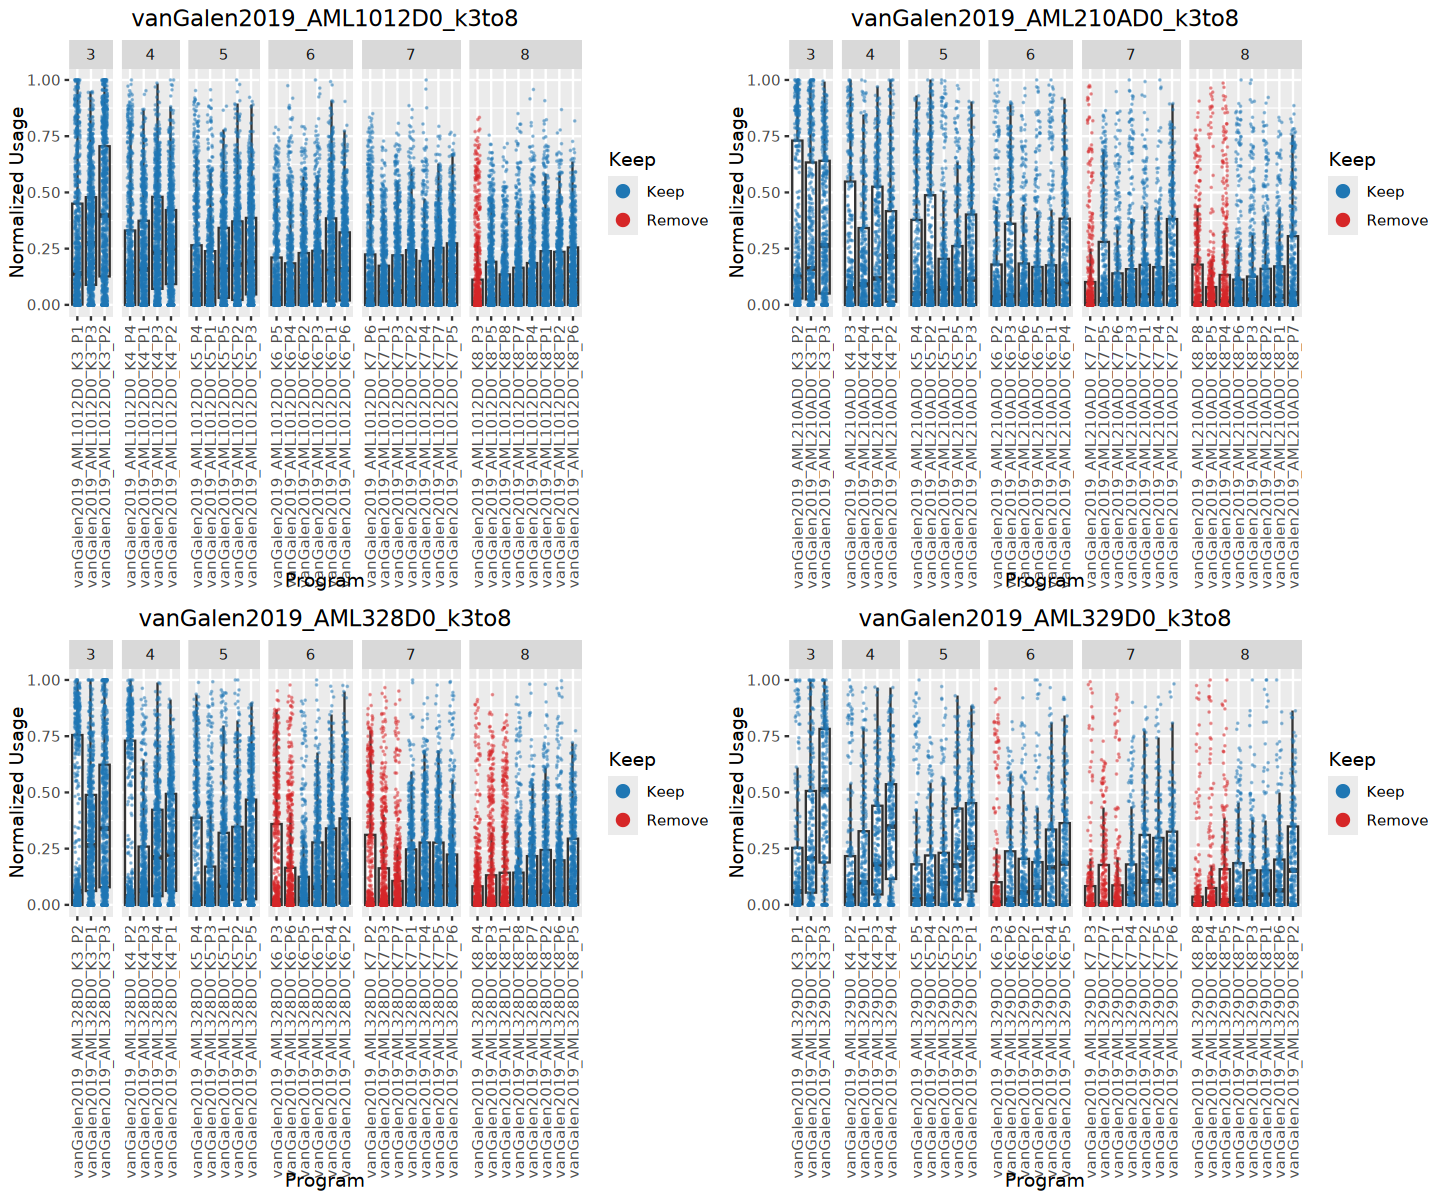

In [5]:
options(repr.plot.width = 12, repr.plot.height = 10)
IQRPlot(ls_WH[1:4], IQR.cut = 0.1, median.cut = 0.02, grid = TRUE)

**RobustProgram**     
After filtering out programs based on IQR and Median thresholds, we identify the robust programs based on their intra- and inter-sample reproducibility.

In [6]:
ls_RP <- RobustProgram(WH.list = ls_WH, IQR.cut = 0.1, median.cut = 0.02)
length(ls_RP)

[1] 55

## Meta Program Generation

In [7]:
# Calculate the overlap gene counts matrix
ovlp <- OverlapMat(ls_RP)

**ClusterMetricsPlot**    
This function plots metrics across a range of cluster numbers to assist in selecting the optimal cluster number.

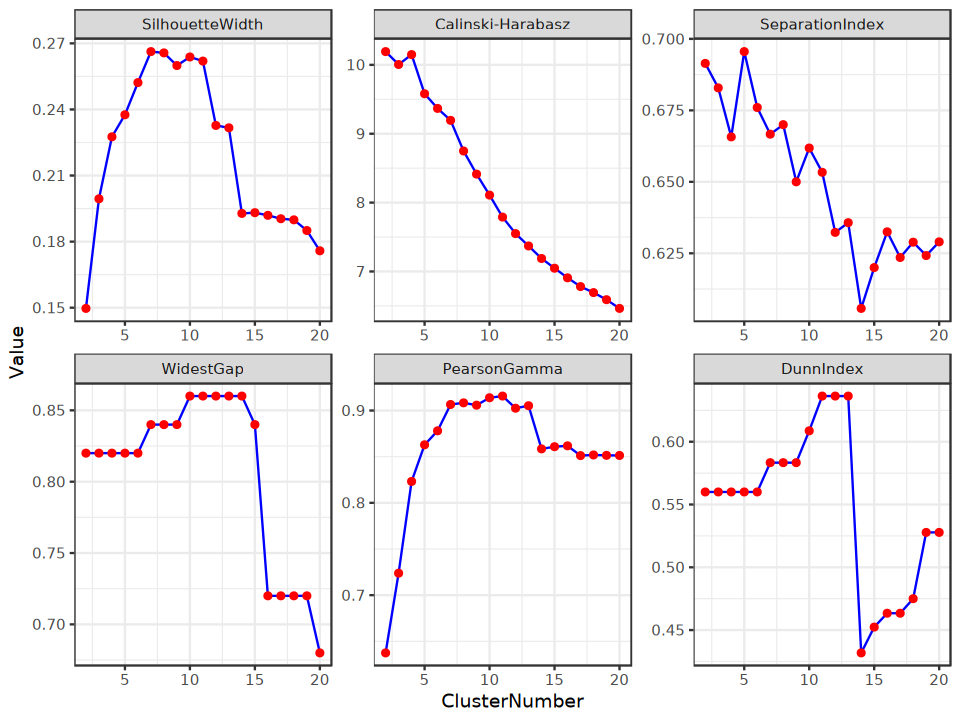

In [8]:
options(repr.plot.width = 8, repr.plot.height = 6)
ClusterMetricsPlot(mat.ovlp = ovlp, 
                   distance.clustering = 'Intersection', 
                   max.intersect = 50, 
                   method.clustering = "ward.D2")

In [9]:
# Here we choose the 7 as the cluster number based on highest average silhouette width
res_cluster <- ClusterPG(mat.ovlp = ovlp, cut.num = 7)
table(res_cluster)

res_cluster
 1  2  3  4  5  6  7 
11 11  9  6  4  7  7 

In [10]:
# Create the Sample annotaion data.frame for meta-program heatmap
Sample <- strsplit(names(res_cluster), '_') %>% 
    sapply(function(s){
        paste0(s[1:2],collapse = '_')
})

df_anno <- data.frame(Sample = Sample)
rownames(df_anno) = names(res_cluster)
all_sam <- unique(df_anno$Sample)
col_sam <- setNames(as.character(paletteer::paletteer_d("ggsci::default_igv"))[1:length(all_sam)], all_sam)
ls_col_anno <- list(Sample = col_sam)

In [11]:
# the annotation data.frame
head(df_anno,3)

,Sample
,<chr>
vanGalen2019_AML420BD0_K3_P1,vanGalen2019_AML420BD0
vanGalen2019_AML707BD0_K3_P1,vanGalen2019_AML707BD0
vanGalen2019_AML921AD0_K5_P3,vanGalen2019_AML921AD0


**MetaProgram**    
Generate the meta programs (MP) based on the cluster result and filter out the meta programs with too manay redundant genes.

The function `MetaProgram` including 3 steps:  
**Step1**: Generate the MP from cluster result. For each MP, the coefficient of genes are calculated from average weight (W matrix of NMF result) of all the programs assigned in this MP and the top genes will be selected as the MP signature.

**Step2**: Remove redundant genes across all MPs, assign the overlap genes by the min rank then max coef across MPs. Then MPs contain no enough genes (`min.size.MP`) are removed.

**Step3**(optional): Draw the heatmap of remaining MPs.

In [12]:
ls_res <- MetaProgram(WH.list = ls_WH, cluster.result = res_cluster,
                     color.mp = rev(as.character(paletteer::paletteer_d(`"RColorBrewer::Set1"`))),
                     show.rownames = FALSE,
                     key = 'Cell state ',
                     min.size.MP = 35, keep.rep.gene = TRUE,
                     annotation = df_anno, color.annotation = ls_col_anno)

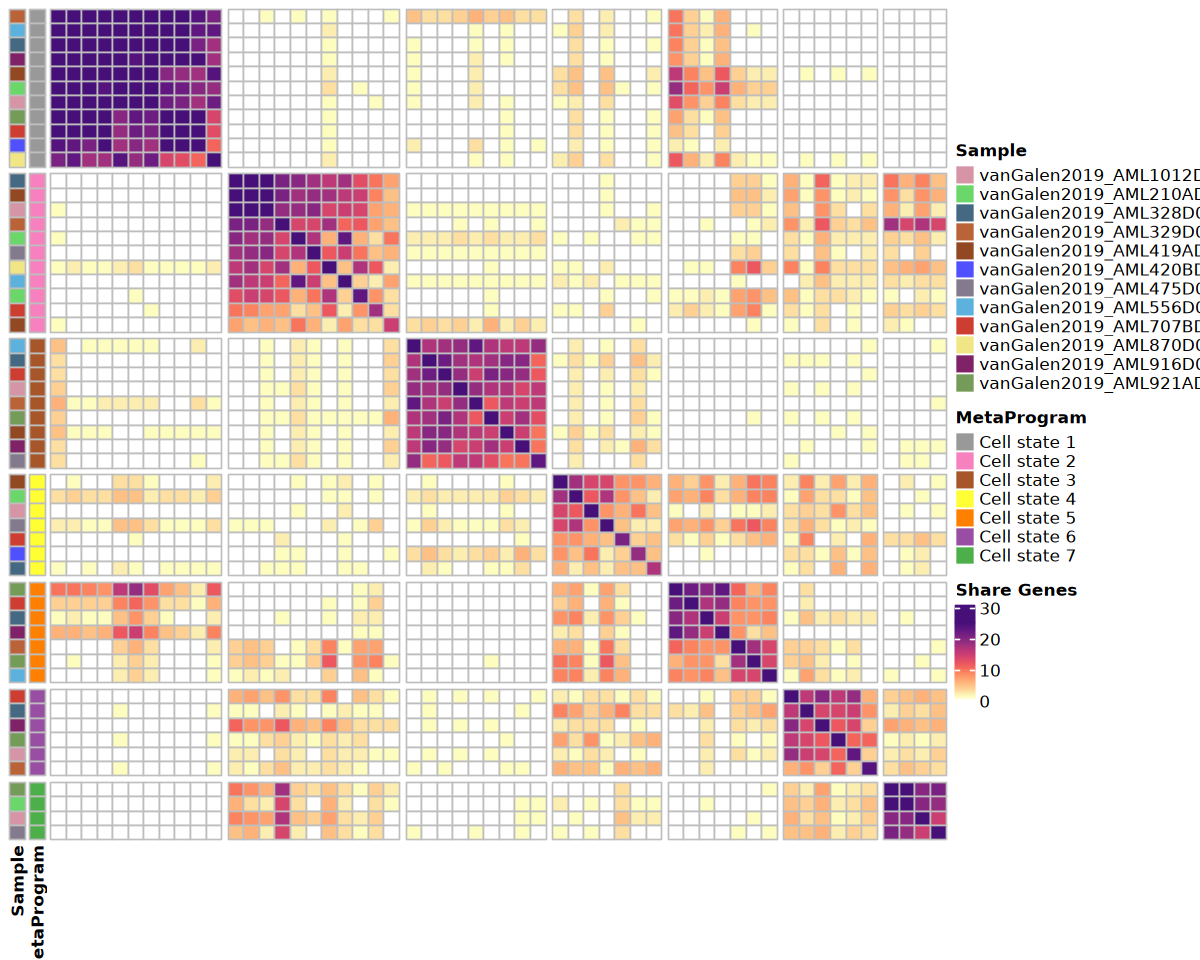

In [13]:
options(repr.plot.width = 10, repr.plot.height = 8)
ls_res$HeatMap

In [14]:
# Print the signature genes 
ls_MP <- ls_res$MetaProgram
sapply(ls_MP,head,5)

Cell state 1,Cell state 2,Cell state 3,Cell state 4,Cell state 5,Cell state 6,Cell state 7
HIST1H4C,S100A9,MALAT1,CDK6,CTSG,CRIP1,HLA-DRA
HIST1H1B,LYZ,NEAT1,SERPINB1,SRGN,ANXA1,HLA-DPA1
HMGB2,S100A8,NKTR,SPINK2,ELANE,VIM,HLA-DPB1
TOP2A,VCAN,LUC7L3,SOX4,MIF,TAGLN2,CD74
MKI67,CTSS,ANKRD36C,TPM4,AZU1,EMP1,HLA-DRB1


## Comparison with the established gene signatures

Next, we opt to examine the association between sciNMF identified cell state signatures and AML cell type signatures from [Zeng et al., Nature Medicine, 2022](https://doi.org/10.1038/s41591-022-01819-x). The gene signature can be downloaded [here](插入数据链接).

In [15]:
Zeng_markers = clusterProfiler::read.gmt("Data/AMLCellType_Genesets.gmt")
Zeng_markers$term = as.character(Zeng_markers$term)
keep.ct = grep("Top250|MLL_LSC", unique(Zeng_markers$term), value = T, invert = T)
Zeng_markers = Zeng_markers[Zeng_markers$term %in% keep.ct,]
Zeng_markers$term = factor(Zeng_markers$term, levels = unique(Zeng_markers$term))
Zeng_markers = split(Zeng_markers$gene, Zeng_markers$term)
Zeng_markers$LSC104_Ng2017_UP = NULL
Zeng_markers$LSC104_Ng2017_DOWN = NULL

Warning message in readLines(gmtfile):
“incomplete final line found on 'Data/AMLCellType_Genesets.gmt'”


In [16]:
Zeng_ovlp = sapply(ls_MP, function(x) {sapply(Zeng_markers, function(y) length(intersect(x, y)))})

In [17]:
library(ComplexHeatmap)
library(RColorBrewer)
library(viridis)
custom_magma <- c(colorRampPalette(c("white", rev(magma(323, begin = 0.15))[1]))(10), rev(magma(323, begin = 0.18)))

Loading required package: grid

ComplexHeatmap version 2.16.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


Loading required package: viridisLite



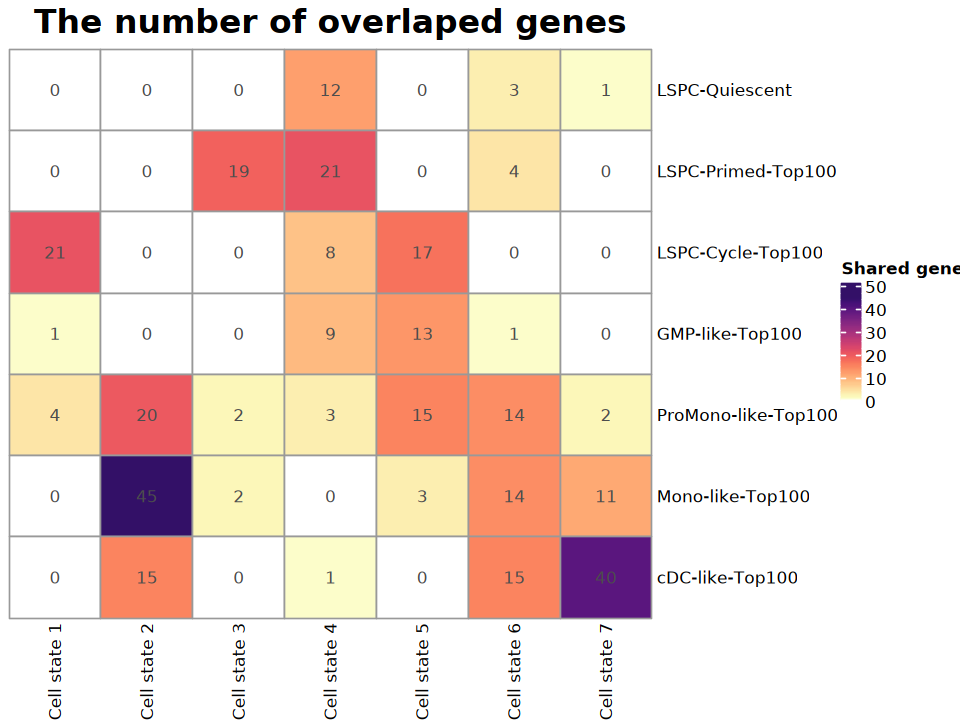

In [18]:
options(repr.plot.width=8, repr.plot.height=6)
p=ComplexHeatmap::pheatmap(Zeng_ovlp, cluster_cols = F, cluster_rows = F, show_colnames = T, show_rownames = T, 
                           main = "The number of overlaped genes", fontsize=15, 
                           fontsize_number=10, fontsize_row=10, fontsize_col=10,
                           name = "Shared genes", gaps_col = NULL,
                           display_numbers = T, number_format = "%.0f", 
                           color=custom_magma)

draw(p)

In summary, sciNMF achieves the characterization of cell state heterogeneity in a simple, rapid, and batch insensitive manner. The resulted cell state signatures capture the heterogeneity of AML malignant cells ([van Galen et al., Cell, 2019](https://doi.org/10.1016/j.cell.2019.01.031); [Zeng et al., Nature Medicine, 2022](https://doi.org/10.1038/s41591-022-01819-x)). 

# System infomation

In [19]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /cluster2/huanglab/rtang/conda/envs/R4.3/lib/libopenblasp-r0.3.23.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Asia/Shanghai
tzcode source: system (glibc)

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] viridis_0.6.4         viridisLite_0.4.2     RColorBrewer_1.1-3   
[4] ComplexHeatmap_2.16.0 Seurat_5.1.0          SeuratObject_5.0.2   
[7] sp_2.0-0              sciNMF_0.1.2         

loaded via a 